The idea behind this notebook is to implement a c-vine based strategy

https://hudsonthames.org/copula-for-statistical-arbitrage-a-c-vine-copula-trading-strategy/

also paper in folder

In [4]:
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import seaborn as sns
import sys
import scipy.stats as stats
import matplotlib.image as mpimg

from matplotlib.pyplot import contourf

pyo.init_notebook_mode(connected=True)

pd.options.plotting.backend = 'plotly'

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, IndependenceCopula)

from scipy.optimize import minimize
from scipy.integrate import quad

# just set the seed for the random number generator
np.random.seed(42)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt


from statsmodels.distributions.copula.api import (FrankCopula, ClaytonCopula, GumbelCopula, GaussianCopula, StudentTCopula, ExtremeValueCopula, IndependenceCopula)
from statsmodels.tools.eval_measures import aic

In [5]:
import pyvinecopulib as pv

Try to create a c-vine from the data

try to calculate the h function from the c-vine

start by trying to create a three item vine copula

write it to a json file

## Import data

In [90]:
#fixing error
import yfinance as yfin
yfin.pdr_override()

end = dt.datetime(2023, 1, 1)
start = dt.datetime(2020,1,1)


stocks = ["BHP", "RIO", "ILU", "SER"]
stocksax = [stock + '.AX' for stock in stocks]

# get all close values
data = pdr.get_data_yahoo(stocksax, start, end)
data = data['Close']

# drop all columns with nan values
data = data.dropna(axis=1)
data.head()

[*********************100%%**********************]  4 of 4 completed


,BHP.AX,ILU.AX,RIO.AX,SER.AX
Date,,,,
2020-01-02,38.950001,9.21,101.150002,0.04
2020-01-03,39.150002,9.23,101.360001,0.04
2020-01-06,39.400002,9.11,101.129997,0.04
2020-01-07,39.549999,9.28,101.739998,0.04
2020-01-08,39.570000,9.15,100.860001,0.04


### Store it locally

In [91]:
# data.to_csv('data.csv')
data = pd.read_csv('data.csv', index_col=0)
data.head()

,BHP.AX,ILU.AX,RIO.AX,SER.AX
Date,,,,
2020-01-02,38.950001,9.21,101.150002,0.04
2020-01-03,39.150002,9.23,101.360001,0.04
2020-01-06,39.400002,9.11,101.129997,0.04
2020-01-07,39.549999,9.28,101.739998,0.04
2020-01-08,39.570000,9.15,100.860001,0.04


## Clean data
eventually choose the best stocks from a basket using kendalls tau or smth

In [92]:
# get log returns

S1 = data['ILU.AX']
S2 = data['RIO.AX']
S3 = data['SER.AX']
S4 = data['BHP.AX'] # BHP is 4 as it is the centre node
# get psudeo observations
#pv.to_pseudo_obs()

lr_1 = (np.log(S1) - np.log(S1.shift(1)))[1:]
lr_2 = (np.log(S2) - np.log(S2.shift(1)))[1:]
lr_3 = (np.log(S3) - np.log(S3.shift(1)))[1:]
lr_4 = (np.log(S4) - np.log(S4.shift(1)))[1:]
pv.to_pseudo_obs(lr_1)

array([[0.525     ],
       [0.25      ],
       [0.78157895],
       [0.22894737],
       [0.575     ],
       [0.725     ],
       [0.41710526],
       [0.89868421],
       [0.50131579],
       [0.24078947],
       [0.69342105],
       [0.48157895],
       [0.56842105],
       [0.5       ],
       [0.125     ],
       [0.64144737],
       [0.02105263],
       [0.98421053],
       [0.71973684],
       [0.65263158],
       [0.04605263],
       [0.41842105],
       [0.96973684],
       [0.71447368],
       [0.19078947],
       [0.225     ],
       [0.56710526],
       [0.29473684],
       [0.42105263],
       [0.52236842],
       [0.59473684],
       [0.00131579],
       [0.57236842],
       [0.98289474],
       [0.03026316],
       [0.17105263],
       [0.16315789],
       [0.06973684],
       [0.18157895],
       [0.04473684],
       [0.30657895],
       [0.60394737],
       [0.68289474],
       [0.65657895],
       [0.08421053],
       [0.00526316],
       [0.99342105],
       [0.175

# C-Vine

In [93]:
structure = pv.CVineStructure([1, 2, 3, 4]) 
u1 = pv.to_pseudo_obs(lr_1)
u2 = pv.to_pseudo_obs(lr_2)
u3 = pv.to_pseudo_obs(lr_3)
u4 = pv.to_pseudo_obs(lr_4)
u = np.array([u1, u2, u3, u4]).T[0] # puts it in a second array so use [0]
#todo change this to make it be trained on training data
vinecop = pv.Vinecop(u, structure=structure)

In [94]:
vinecop.str

<bound method PyCapsule.str of <pyvinecopulib.Vinecop>
** Tree: 0
1,4 <-> TLL, parameters = [30x30 grid]
2,4 <-> Student, parameters = 0.863357
 4.55432
3,4 <-> TLL, parameters = [30x30 grid]
** Tree: 1
1,3 | 4 <-> TLL, parameters = [30x30 grid]
2,3 | 4 <-> Independence
** Tree: 2
1,2 | 3,4 <-> TLL, parameters = [30x30 grid]
>

In [95]:
def conditional_probs(vinecop, data, tree, out='array', hfunc2=True):
    """Returns the conditional probability for each node with regard to the center (only works for c-vines)
    
    """
    order = vinecop.order # [1, 2, 3, 4]
    #order = ["1|4", "2|4", "3|4"]
    bicopList = vinecop.pair_copulas[tree]

    # calculate the number of nodes from the number of edges (by adding 1)
    numNodes = len(bicopList)+1

    # phasing out order 

    # first, find the conditional probability of each of the previous with respect to the last in order
    center = numNodes
    hFrame = pd.DataFrame()

    for i in range(1, numNodes, 1): # done in this order to match the list of copulas, 1|4 first, then 2|4 etc.
        # if updates:
        #     print(f"calculating {order[i-1]}|{center}")
        # get the two columns
        S_center = data.T[numNodes-1].T
        S_i = data.T[i-1].T

        # get the copula
        bicop = bicopList[i-1]
        if hfunc2:
            h = bicop.hfunc2(np.array([S_i, S_center]).T)
        else:
            h = bicop.hfunc1(np.array([S_i, S_center]).T)
        hFrame[f"{i-1}|{center}"] = h
    if out == 'array':
        hFrame = np.array(hFrame)

    return hFrame

In [96]:
cond_probs = u
for i in range(len(vinecop.pair_copulas)-1):
    cond_probs = conditional_probs(vinecop, cond_probs, i)
    print(f"tree {i} complete")

# get the two different probs for the final
MI_uv = conditional_probs(vinecop, cond_probs, len(vinecop.pair_copulas)-1, hfunc2=True)
MI_vu = conditional_probs(vinecop, cond_probs, len(vinecop.pair_copulas)-1, hfunc2=False)
MI_uv[:10]

tree 0 complete
tree 1 complete


array([[0.4530255 ],
       [0.15527963],
       [0.84829422],
       [0.23087243],
       [0.35786387],
       [0.68557702],
       [0.5820846 ],
       [0.91488623],
       [0.55936114],
       [0.14300899]])

# Write a super simple backtester (no test train data)

add MI-0.5 each time to the flag

reset if it passes 2 and exit positions

sell if > 0.6 and buy if < -0.6

In [118]:
stock_data = S4[1:] # drop the first i
flagX = 0*S4
#flagY = 0*S4

weight = 1 # weight of trades (1 means buy/sell 1 stock each trade)
CL = 0.6 # confidence level
TH = 2 # exit threshold

returns = 0*S4 # liquid cash
total_returns = 0*S4 # liquid cash and stocks
num_S4 = 0*S4


for i in range(1, len(S4)): # S4-1 to get the length of the conditional probs
    returns[i] = returns[i-1]
    num_S4[i] = num_S4[i-1]
    total_returns[i] = total_returns[i-1]

    flagX[i] = flagX[i-1] + (MI_uv[i-1] - 0.5) # use i-1 for conditional probs as it "starts"
    #flagY[i] = flagY[i-1] + (MI_vu[i-1] - 0.5) # only use flagX for now, and use it to buy or sell BHP stock (S4)

    # therefore S4 is overpriced (sell S4)
    if flagX[i] > CL:
        returns[i] += weight*S4[i]
        # sell S4
        num_S4[i] -= weight

     # therefore S4 is underpriced (buy S4)
    elif flagX[i] < -CL:
        returns[i] -= weight*S4[i]
        # buy S4
        num_S4[i] += weight

    # exit all positions
    if np.abs(flagX[i]) > TH:
        flagX[i] = 0
        returns[i] += num_S4[i]*S4[i]
        num_S4[i] = 0

    total_returns[i] = returns[i] + num_S4[i]*S4[i]

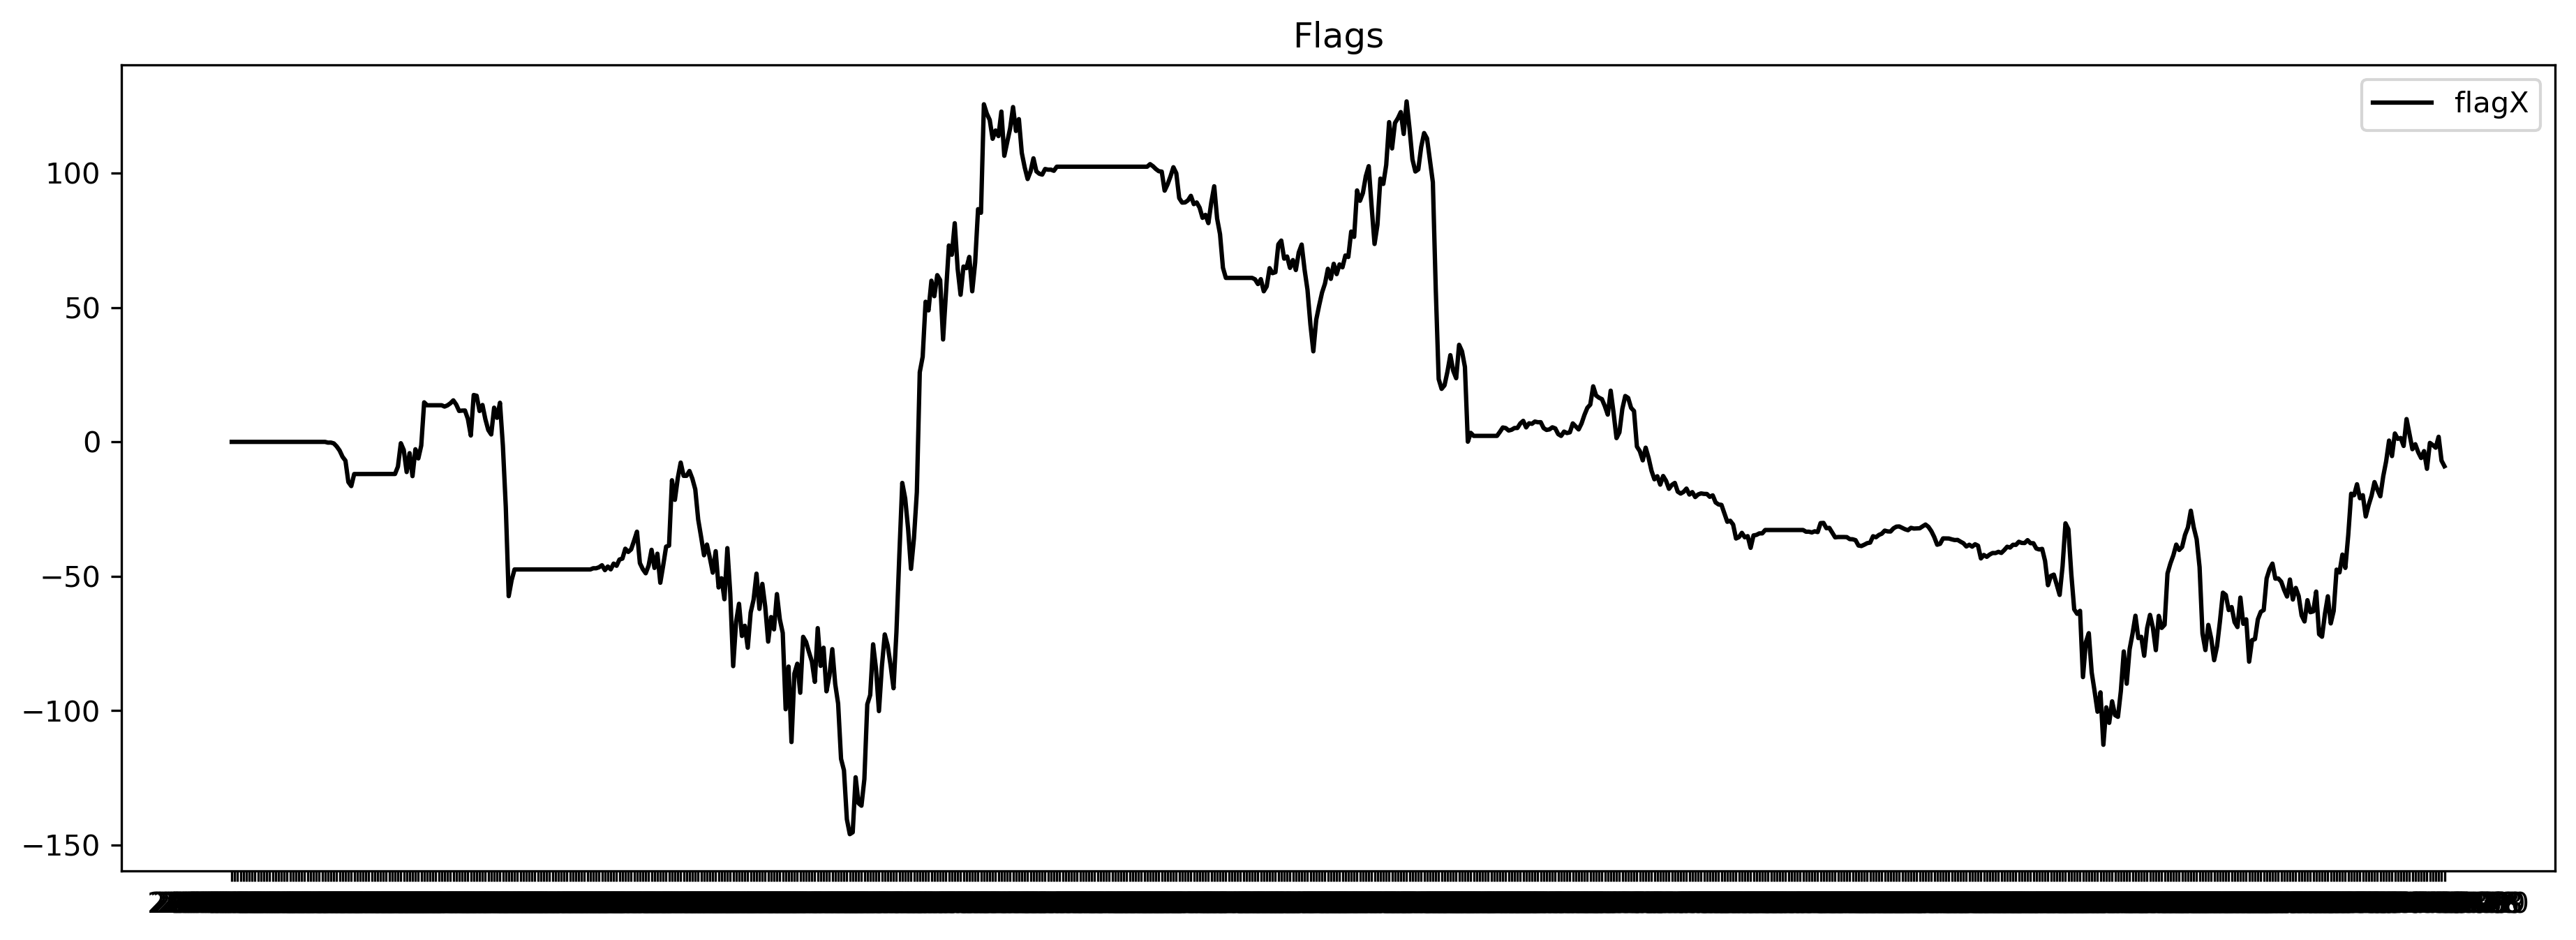

In [115]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("returns")
plt.plot(total_returns, color='black')

plt.legend(['flagX', 'flagY'])
plt.show()

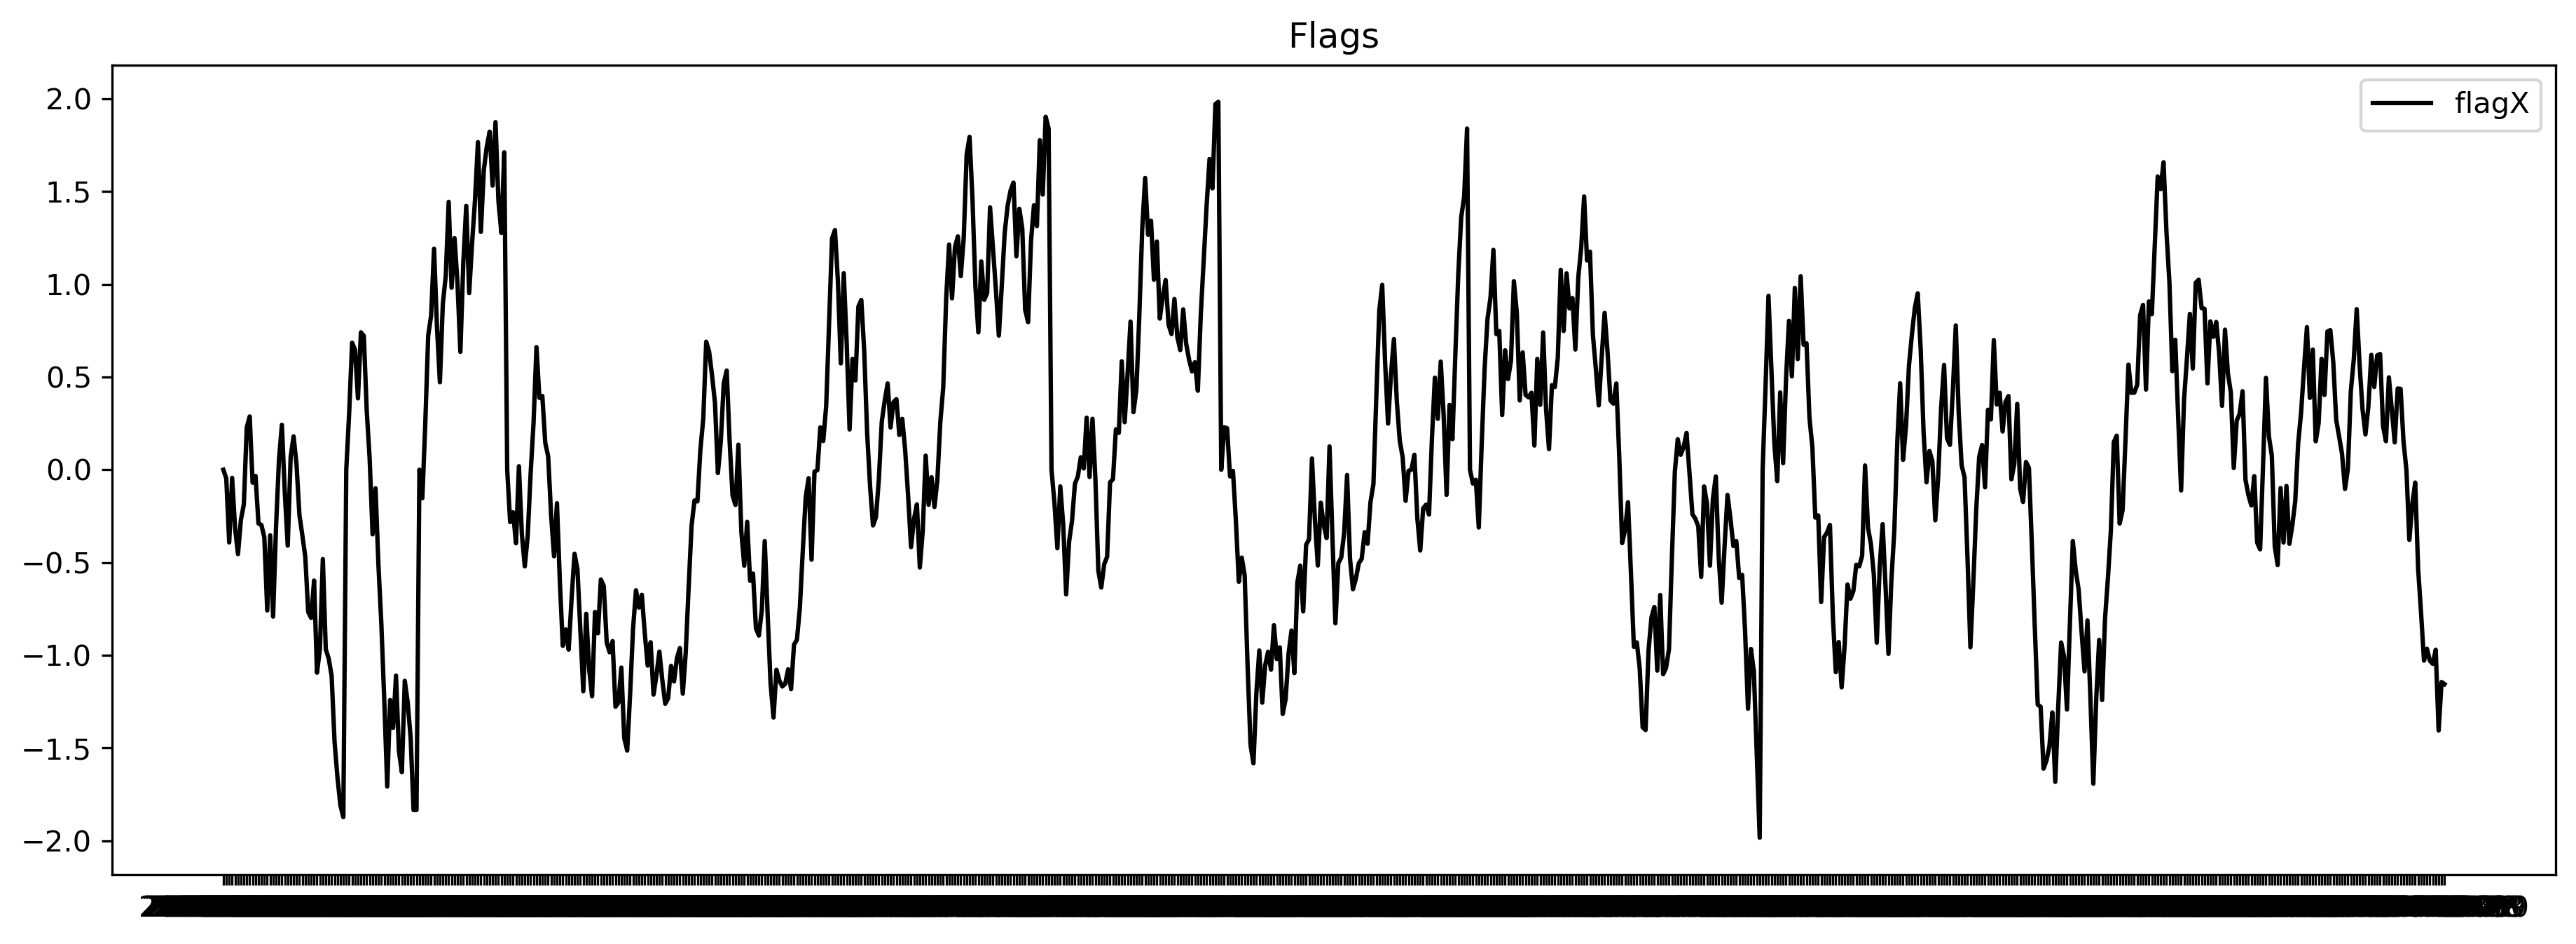

In [119]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Flags")
plt.plot(flagX, color='black')

plt.legend(['flagX', 'flagY'])
plt.show()

Index(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07', '2013-01-08',
       '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-14', '2013-01-15',
       ...
       '2022-12-15', '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
       '2022-12-22', '2022-12-23', '2022-12-28', '2022-12-29', '2022-12-30'],
      dtype='object', name='Date', length=2532)

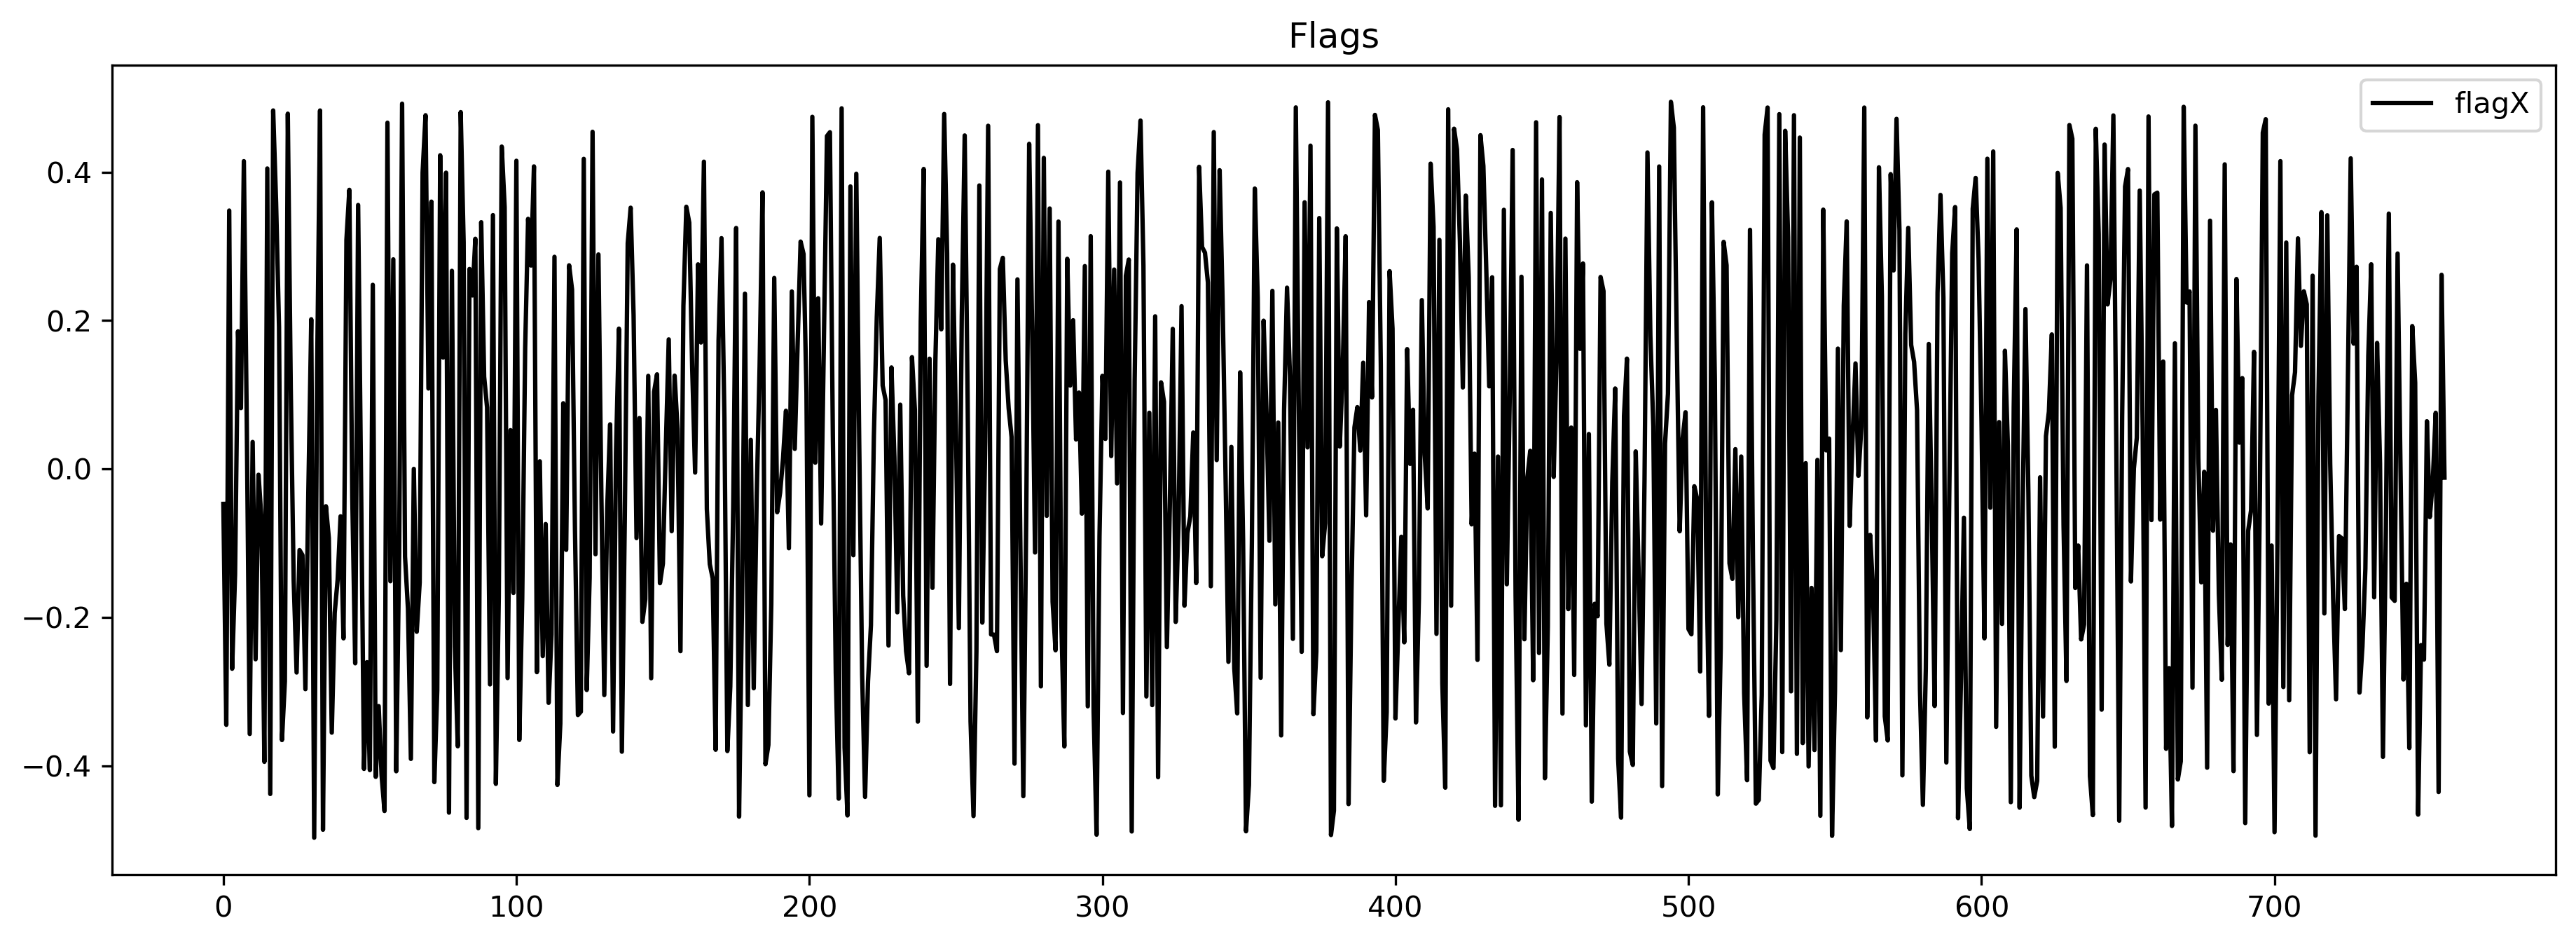

In [117]:

# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Flags")
plt.plot(MI_uv-0.5, color='black')

plt.legend(['flagX', 'flagY'])
plt.show()

# stat 2

In [120]:
cond_probs = u
for i in range(len(vinecop.pair_copulas)-1):
    cond_probs = conditional_probs(vinecop, cond_probs, i)
    print(f"tree {i} complete")

# get the two different probs for the final
MI_uv = conditional_probs(vinecop, cond_probs, len(vinecop.pair_copulas)-1, hfunc2=True)
MI_vu = conditional_probs(vinecop, cond_probs, len(vinecop.pair_copulas)-1, hfunc2=False)
MI_uv[:10]

tree 0 complete
tree 1 complete


array([[0.4530255 ],
       [0.15527963],
       [0.84829422],
       [0.23087243],
       [0.35786387],
       [0.68557702],
       [0.5820846 ],
       [0.91488623],
       [0.55936114],
       [0.14300899]])

In [188]:
ratio = 0.7
split = int(ratio*len(S4))
train_u = u[:split]
test_u = u[split:]
test_S4 = S4[1:][split:]

### Train the model
structure = pv.CVineStructure([1, 2, 3, 4]) 
#vinecop = pv.Vinecop(train_u, structure=structure)

### test the model
cond_probs = test_u
for i in range(len(vinecop.pair_copulas)):
    cond_probs = conditional_probs(vinecop, cond_probs, i)
    print(f"tree {i} complete")

#cond_probs = vinecop.cdf(test_u)/vinecop.cdf(((test_u*0)+1))
cond_probs = vinecop.cdf(test_u)

# # get the two different probs for the final
# MI_uv = conditional_probs(vinecop, cond_probs, len(vinecop.pair_copulas)-1, hfunc2=True)
# MI_vu = conditional_probs(vinecop, cond_probs, len(vinecop.pair_copulas)-1, hfunc2=False)
# MI_uv[:10]

returns = 0
num_S4 = 0
weight = 1
total_returns = 0*test_S4

for i in range(0, len(test_S4), 1):
    #total_returns[i] = total_returns[i-1]
    MI = cond_probs[i]

    if MI > 0.95: # overpriced
        num_S4 -= weight
        returns += weight*test_S4[i]
    elif MI < 0.05: # underpriced
        num_S4 += weight
        returns -= weight*test_S4[i]

    total_returns[i] = returns + num_S4*test_S4[i]

tree 0 complete
tree 1 complete
tree 2 complete


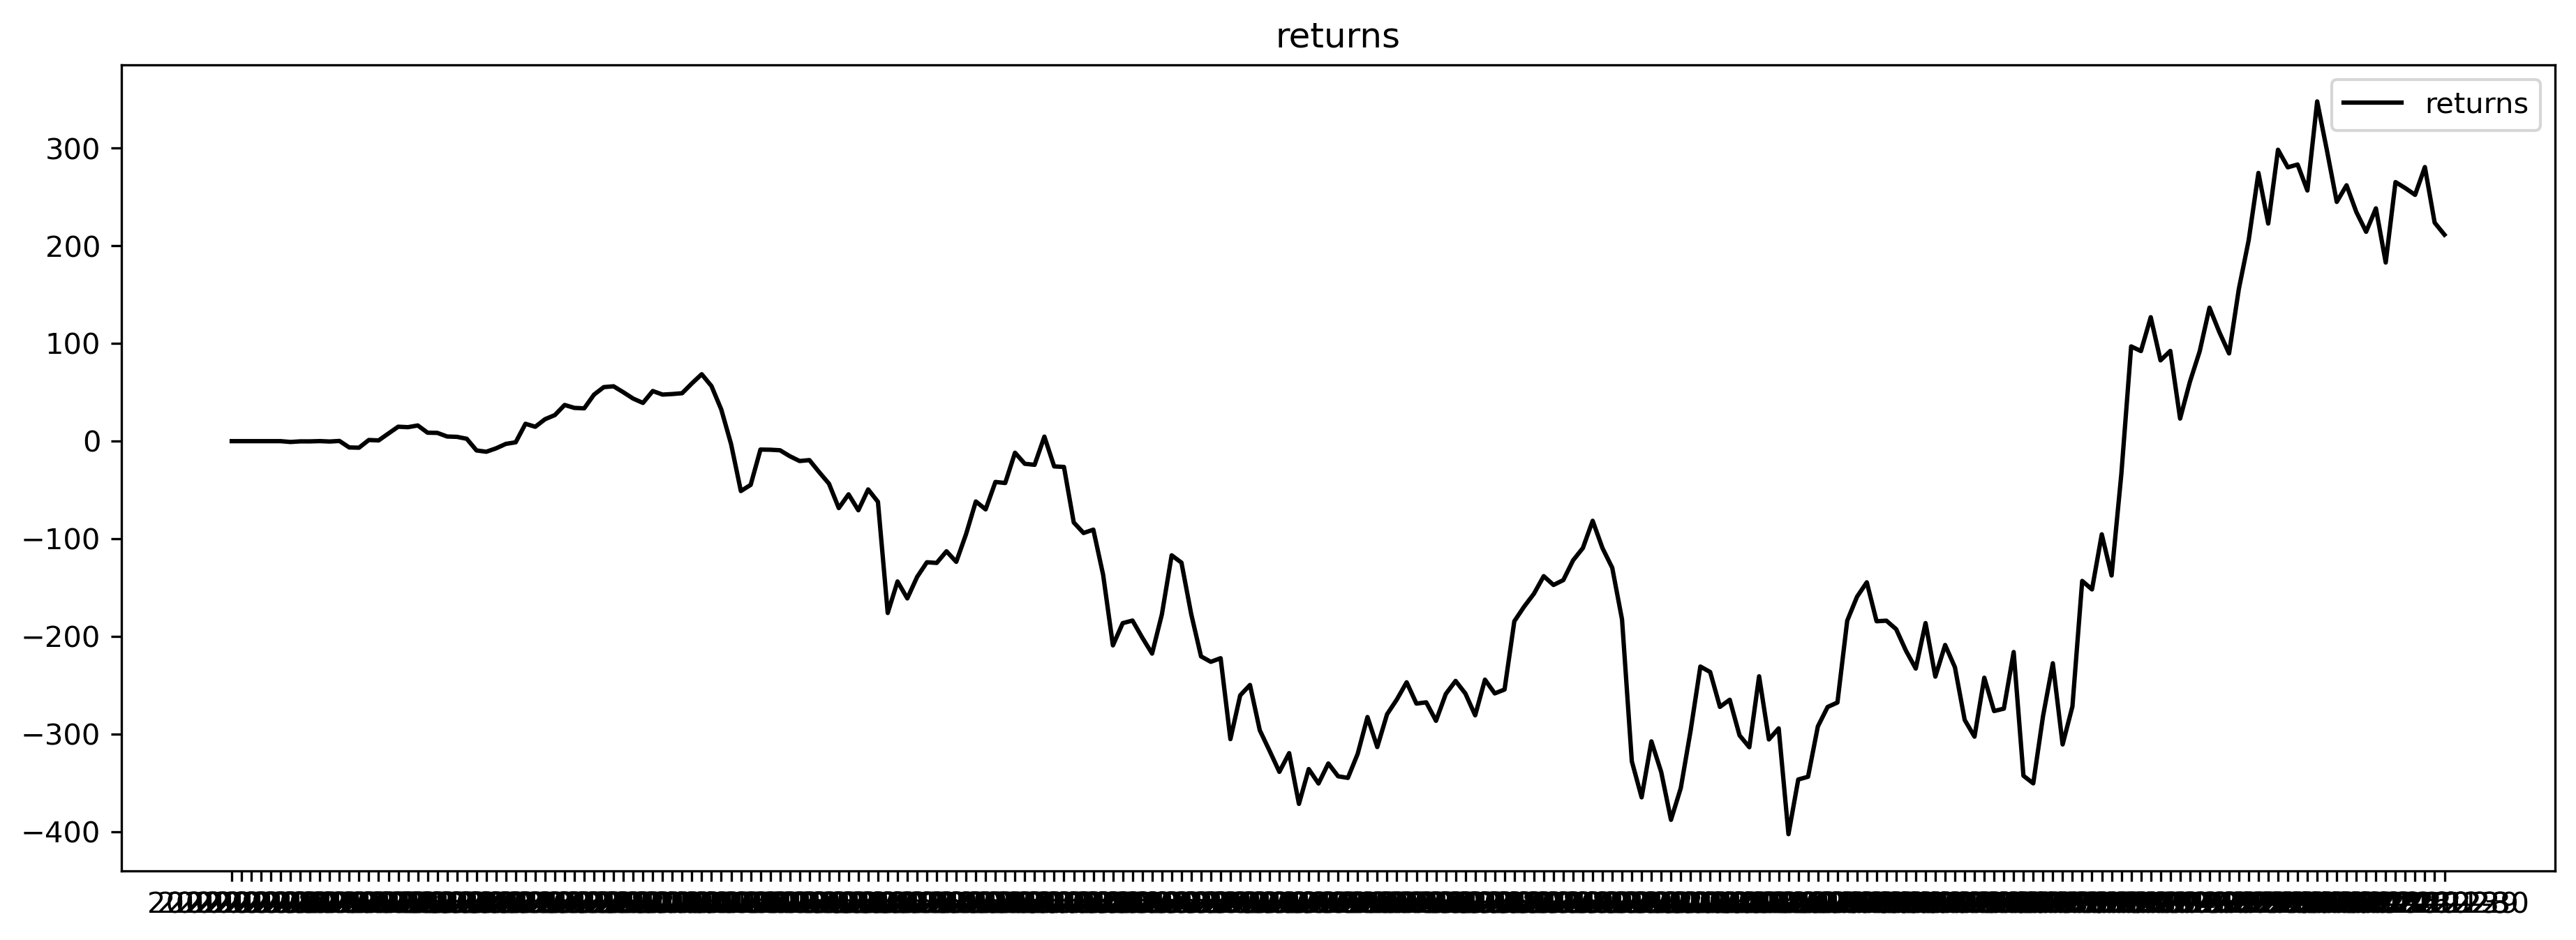

In [189]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("returns")
plt.plot(total_returns, color='black')

plt.legend(['returns', 'flagY'])
plt.show()

In [173]:
vinecop.cdf(u)[:5], vinecop.pdf(u)[:5]

(array([0.1921, 0.1026, 0.2447, 0.0788, 0.257 ]),
 array([3.2852674 , 1.31985519, 2.53212461, 1.65429017, 3.76732   ]))

In [193]:
vinecop.cdf(u)

array([1.974e-01, 1.072e-01, 2.547e-01, 8.240e-02, 2.621e-01, 3.570e-01,
       1.151e-01, 3.717e-01, 1.870e-02, 1.031e-01, 3.074e-01, 2.240e-01,
       3.289e-01, 1.938e-01, 4.700e-03, 3.130e-02, 1.000e-04, 5.110e-01,
       2.200e-03, 1.870e-01, 1.140e-02, 3.010e-01, 3.648e-01, 2.887e-01,
       2.800e-03, 8.090e-02, 3.673e-01, 6.700e-03, 3.177e-01, 2.820e-01,
       2.550e-02, 1.000e-04, 2.474e-01, 2.980e-02, 1.270e-02, 3.180e-02,
       3.370e-02, 1.930e-02, 4.900e-02, 4.900e-03, 8.380e-02, 3.030e-01,
       1.452e-01, 7.920e-02, 1.060e-02, 2.000e-04, 4.984e-01, 3.130e-02,
       4.000e-04, 9.200e-03, 1.200e-03, 5.114e-01, 3.000e-03, 1.694e-01,
       4.200e-02, 1.400e-03, 3.837e-01, 4.986e-01, 7.050e-02, 2.000e-03,
       3.732e-01, 1.220e-02, 4.564e-01, 1.100e-03, 3.973e-01, 3.913e-01,
       1.359e-01, 1.052e-01, 2.468e-01, 8.200e-03, 9.450e-02, 5.440e-02,
       1.137e-01, 1.360e-02, 3.540e-02, 1.480e-02, 3.651e-01, 1.003e-01,
       1.790e-01, 1.214e-01, 7.600e-03, 4.656e-01, 

In [196]:
vinecop.pdf(test_u)

array([6.75751122e-01, 4.94740840e-01, 2.66854230e-01, 4.51532779e-01,
       5.08452357e-01, 2.82787018e-01, 1.78398398e-01, 2.06243108e+00,
       2.45904624e+00, 1.59939382e+00, 4.12056717e+00, 1.46984641e+00,
       4.28501975e+01, 7.37524801e-01, 5.39327996e+01, 3.10368342e+00,
       1.82134036e+01, 6.42440641e-01, 1.83413354e+00, 1.10403902e+00,
       1.16389399e+02, 2.28307743e+00, 3.12991768e-02, 1.40757301e+00,
       3.24215625e+00, 5.59291611e+01, 2.62705058e+00, 4.88092099e+00,
       2.66265451e+00, 1.99172395e+00, 6.31731342e+00, 2.35195063e+00,
       2.12922180e+00, 2.56000029e+00, 5.52702131e+00, 1.93408557e+00,
       2.25816295e+00, 7.86766402e+00, 4.22841279e+00, 1.69090870e+00,
       8.77306133e-01, 3.80380558e+00, 2.26841086e+00, 1.12920088e+00,
       1.99669509e+00, 2.67802942e+00, 4.65580962e-01, 4.87426763e-01,
       7.55892499e-01, 5.29220538e+00, 3.79277090e+00, 1.55013339e+01,
       3.30561099e+02, 2.71040268e+00, 4.31068505e+01, 2.70080424e+00,
      

In [1]:
from yahoo_fin import options as op

In [3]:
ticker = "AAPL"
expirationDates = op.get_expiration_dates(ticker)

NameError: name 'HTMLSession' is not defined

NameError: name 'HTMLSession' is not defined